# Introduction

This notebook guides the Reader through a set of code-snippets in python, which show what I've recently learned about working with (small) graphs.

The running example of a graph that we will be analyzing is a small social network, the "hello-world" of network science, the Zachary's karate club network ([wikipedia: Zachary karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)).

The main motivation of this work is to reproduce in an interactive environment of a jupyter-notebook the discussion presented in the blogpost from 30.09.2016 by Thomas Kipf: http://tkipf.github.io/graph-convolutional-networks/.

The author introduces a simple example of a neural network, a machine-learning model that operates on a single graph and adjust its parameters by backpropagation. The goal of the model is semi-supervised learning, i.e. label propagation: that is classification of all nodes in the graph where only fraction of the nodes is classified to begin with. The post is meant as a popular introduction to the scientific paper by *T. Kipf, M. Welling* (ICLR 2017, [1609.02907](https://arxiv.org/abs/1609.02907), [openreviews](https://openreview.net/forum?id=SJU4ayYgl)). The Zachary's network is a good candidate problem because its nodes come with one of the two labels, which correspond to a split in the social structure of the karate club originating from a disagreement between nodes `0` and `33`. So, our goal will be two predict labels for all other nodes given that node `0` is labeled differently than node `33`.

Our models will have only the graph-structure of the social network as a source of information. The overarching assumption of this sort of work is that by observing how well predictions of a given model align with what actually happend in the real world, we can infer how well mathematical assumptions baked into the model align with complexities of the real-world interactions.

But, before we discuss the neural network, we slowly introduce basic syntax of two popular python libraries for working with graphs:
* networkx (https://networkx.github.io/documentation/stable/)
* python-igraph (https://igraph.org/python/)

* Also, we will be using capabilities of another python package dedicated to producing interesting graph-embeddings: https://github.com/palash1992/GEM by *P. Goyal* (University of Southern California). This package is itself a companion to a review article about graph embeddings: https://arxiv.org/abs/1705.02801. 

(The README file accompaning this notebook has some remarks about installation.)

After that we'll introduce basic syntax of `pytorch` library. We'll use an array type structure and some nonlinear activation functions build into this library to define our neural network. And the autodifferentiating capabilities of `pytorch` will serve to easily implement the training. In the end we'll use our newly gained experience with graph plotting to inspect predictions of the neural network.

That part of the notebook has drawn inspiration from a the two-part series of nice blogposts by *Tobias Skovgaard Jepsen*:
* [how-to-do-deep-learning-on-graphs-with-graph-convolutional-network Part 1.](https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-7d2250723780)
* [how-to-do-deep-learning-on-graphs-with-graph-convolutional-network Part 2.](https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-62acf5b143d0)

(which also are intended as an elementary explanation of the blogpost by *Thomas Kipf*). The main difference between the current notebook and the material presented in those two blogposts is perhas that we will be introducing and using `pytorch` whereas *Tobias Skovgaard Jepsen* opted for `MXNet` which is another great deep-learning library (notably, it is distributed and developed under the Apache Licence).

If You'll find Yourself curious about `pytorch`, I recommend to start with these three short and sweet tutorials from the offical website:
* [What is PyTorch?](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py)
* [Automatic Differentiation](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)
* [Learning PyTorch with Examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)

It should be stressed that the Zachary's karate club network is a very small and rather unsophisticated graph. So none of our results will exactly be mindblowing. That is not our goal. We aim to provide a nice tutorial and reference for begginers (including the present author) to play and experiment with, and to build on.

---
# Setup

Ignore warnigs for the sake of aesthetics.

Be sure to comment this out, when experimenting with the code!

In [479]:
import warnings
warnings.filterwarnings("ignore")

Import packages

In [477]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import igraph as ig
import torch
from itertools import cycle

import gem
from gem.utils import graph_util, plot_util
from gem.evaluation import visualize_embedding as viz
from gem.evaluation import evaluate_graph_reconstruction as gr
from time import time

from gem.embedding.gf       import GraphFactorization
from gem.embedding.hope     import HOPE
from gem.embedding.lap      import LaplacianEigenmaps
from gem.embedding.lle      import LocallyLinearEmbedding
from gem.embedding.node2vec import node2vec
from gem.embedding.sdne     import SDNE

import sklearn
from sklearn.manifold import TSNE
tsne = TSNE(2)
from sklearn.decomposition import  PCA
pca = PCA(2)

Print out version-number of the packages

In [531]:
# versions of the most important packages that we happen to be using
for name, package in [("numpy", np),\
                      ("matplotlib", matplotlib),\
                      ("networkx", nx),\
                      ("igraph", ig),\
                      ("scikit-learn", sklearn),\
                      ("pytorch", torch)
                     ]:
    print(f"{name:>13}: {package.__version__}")

        numpy: 1.17.2
   matplotlib: 2.2.3
     networkx: 2.3
       igraph: 0.7.1
 scikit-learn: 0.21.3
      pytorch: 1.2.0+cpu


For the sake of `node2vec` method from `gem.embedding` we need to have an appropriate executable binary in our `PATH` (see the README or https://github.com/palash1992/GEM). We can modify `PATH` from within python using the `os` module.

In [486]:
import os
#os.environ['PATH'] += ":/home/olszewskip/Downloads/Snap-5.0/examples/node2vec/"
!echo $PATH
!ls -l /home/olszewskip/Downloads/Snap-5.0/examples/node2vec/node2vec

/home/olszewskip/miniconda3/envs/py36data/bin:/home/olszewskip/miniconda3/condabin:/home/olszewskip/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/home/olszewskip/Downloads/Snap-5.0/examples/node2vec/node2vec:/home/olszewskip/Downloads/Snap-5.0/examples/node2vec/
-rwxr-xr-x 1 olszewskip olszewskip 3689120 wrz 11 01:56 /home/olszewskip/Downloads/Snap-5.0/examples/node2vec/node2vec


---
# Basic plotting

The karate graph comes bundled with the `networkx` package.

In [487]:
karate_nx = nx.karate_club_graph()

It can be immediatelly plotted. Networkx has used here the default (random) layout, known as $Fruchterman - Reingold$.

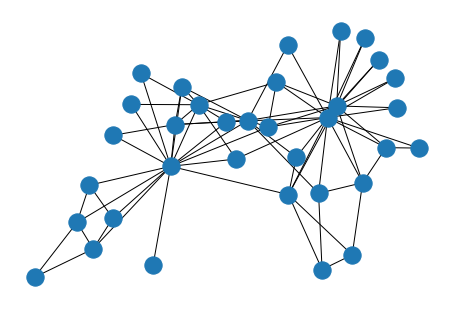

In [491]:
nx.draw(karate_nx)

Attributes of the nodes can be accesed in the following manner.

In [532]:
for id_ in [0, 10, 20, 33]:
    print(id_, karate_nx.node[id_])

0 {'club': 'Mr. Hi'}
10 {'club': 'Mr. Hi'}
20 {'club': 'Officer'}
33 {'club': 'Officer'}


In our case, each node is assigned to one of two "clubs":
* "Mr. Hi" (node `0`)
* "Officer" (node `33`).

---
One can easily use the `networkx` graph to construct a graph in `igraph`.

In [31]:
karate_ig = ig.Graph(list(karate_nx.edges()), directed=False)
for id in karate_nx.nodes():
    ig_node = karate_ig.vs.find(id)
    ig_node["name"] = id
    for key, value in karate_nx.node[id].items():
        ig_node[key] = value
    if ig_node['club'] == "Mr. Hi":
        ig_node['shape'] = 'rectangle'
    if ig_node['club'] == "Officer":
        ig_node['shape'] = 'circle'
    if id == 0:
        ig_node['shape'] = 'triangle-up'
    if id == 33:
        ig_node['shape'] = 'triangle-down'

Here we have already assigned `shape` attributes to nodes in the `igraph` object. Those are automatically used by `igraph` during plotting.

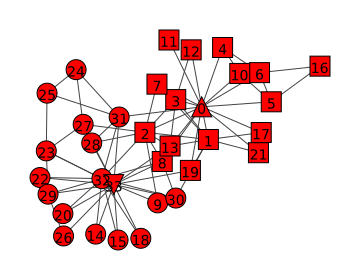

In [498]:
ig_plot_kwargs = {'bbox': (360, 280), 'margin': 40}
ig.plot(karate_ig,\
        vertex_label=range(len(karate_ig.vs())),\
        **ig_plot_kwargs)

Thus, finally we can observe which nodes belong to which club.

Unsurprisingly, nodes close to "Mr. Hi."(triangle-up) belong to the first club (squares), and nodes close to the "Officer" (triangle down) to the second (circles).

---
The `networkx` package seems easier to use, and to control aesthetics of the plot.
In particular, we can split the plotting process into separate function calls for plotting nodes, edges, labels, etc., see the documentation for details:
* https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw

Here's an example, where we plot the two clubs in different colors (yellow and blue) and the two disagreeing nodes are marked with darker colors.

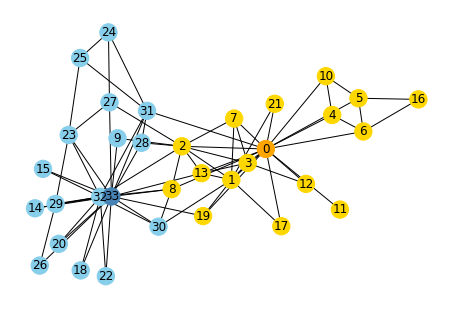

In [500]:
club2aesthetic =\
{'Mr. Hi': {'colors': ('gold', 'orange'), 'special_id': 0},
 'Officer': {'colors': ('skyblue', 'steelblue'), 'special_id': 33}
}

for club in club2aesthetic:
    special_id = club2aesthetic[club]['special_id']
    assert karate_nx.node[special_id]['club'] == club
    
colors = [club2aesthetic[karate_nx.node[id_]['club']]['colors'][0] for id_ in karate_nx.nodes()]
for club, aesthetic in club2aesthetic.items():
    special_id = aesthetic['special_id']
    special_color = aesthetic['colors'][1]
    colors[special_id] = special_color

labels = {id_: id_ for id_ in karate_nx}

nx.draw(karate_nx, node_color=colors, labels=labels)

---
Another dimension of the aethetics that we can easily control are shapes of the nodes. Let's define a function that serves to plot a subset (a `community`) of the nodes using a specified shape. The available shapes are denoted as one of the following letters: `so^>v<dph8`.

In [12]:
def plot_club_nodes(community, community_label, node_shape, club, pos, node_size=200):
    # 
    subgraph = nx.Graph()
    ids = [id_ for id_ in community\
           if karate_nx.node[id_]['club'] == club]
    special_id = club2aesthetic[club]['special_id']
    if special_id in community:
        subgraph_0 = nx.Graph()
        subgraph_0.add_node(special_id)
        ids.remove(special_id)
        nx.draw_networkx_nodes(subgraph_0,\
                               pos,\
                               node_size=node_size,\
                               node_color = club2aesthetic[club]['colors'][1],\
                               node_shape = node_shape
                              )
    subgraph.add_nodes_from(ids)
    # drawing
    nx.draw_networkx_nodes(subgraph,\
                           pos,\
                           node_size=node_size,\
                           node_color = club2aesthetic[club]['colors'][0],\
                           node_shape = node_shape,\
                           alpha=0.7,\
                           label = f"{club}, community {community_label}"
                          )

And here's an example of how we can use this function, controlling
* the choice of nodes
* graph layout (`pos` argument)
* shape of the nodes

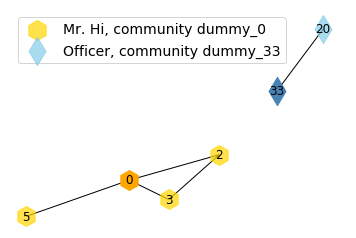

In [519]:
pos = nx.fruchterman_reingold_layout(karate_nx)
dummy_subgraph = karate_nx.subgraph([0,2,3,5,20,33])
plot_club_nodes([0,2,3,5], community_label="dummy_0", node_shape="h", club="Mr. Hi", pos=pos, node_size=400)
plot_club_nodes([20, 33], community_label="dummy_33", node_shape="d", club="Officer", pos=pos, node_size=400)
nx.draw_networkx_labels(dummy_subgraph, pos=pos, font_size=12)
nx.draw_networkx_edges(dummy_subgraph, pos=pos)
plt.legend(prop={'size': 14})
plt.axis("off")
plt.show()

---
## Simple label propagation

Going back to the karate club: the `igraph` package in turn has a lot of sophisticated algorithms efficiently implemented and easily callable as graph methods. One of them, `community_label_propagation`, serves to answer our main question: it can propagate the two labels from nodes `0` and `33` to all other nodes.

The method uses **algorithm by *Raghavan, Albert, Kumara* from 2007** (https://arxiv.org/abs/0709.2938). (No neural network is used yet.) Is short:
* the algorith processes nodes one-by-one in a random order,
* each node is assigned a label by majority voting of its neighbors.

You can read more e.g. in this blogpost: https://towardsdatascience.com/large-scale-graph-mining-with-spark-part-2-2c3d9ed15bb5.

Here's how we can use this algorithm and plot its results:
1. Label node `0` as 0, node `33` as 1, and every other node as -1 (which stands for an unknown label to be determined by the algorithm).

In [503]:
initial_labels = - np.ones(len(karate_ig.vs)) # -1 stands for unknown
initial_labels[0] = 0
initial_labels[33] = 1
fixed = np.zeros(len(karate_ig.vs), dtype='bool')
fixed[0] = fixed[33] = True # True valus mark ground-true nodes (presumed to have initial labels)

2. Call the method

In [33]:
propagated_communities = karate_ig.community_label_propagation(initial = initial_labels, fixed=fixed)
list(propagated_communities)

[[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21],
 [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]

3. Draw using the previously defined function.

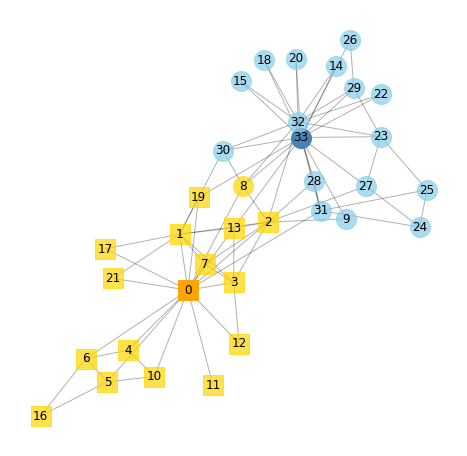

In [525]:
pos = nx.fruchterman_reingold_layout(karate_nx)
plt.figure(figsize=(8,8))
nx.draw_networkx_edges(karate_nx, pos=pos, alpha=0.3)
nx.draw_networkx_labels(karate_nx, pos=pos, font_size=12)
for club in ['Mr. Hi', 'Officer']:
    for community, node_shape in zip(propagated_communities, cycle("sod^v><ph8")):
        plot_club_nodes(community, None, node_shape, club, pos, node_size=400)

plt.axis("off")
plt.show()

`igraph` also has a very nice build-in capability of drawing the communities with a colorful contours

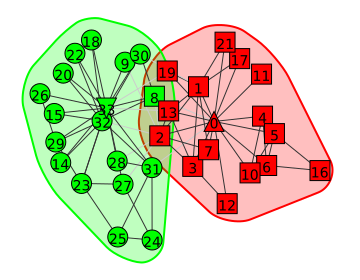

In [275]:
ig.plot(propagated_communities,\
        vertex_label=range(len(karate_ig.vs())),\
        mark_groups=True,\
        **ig_plot_kwargs)

Somewhat confusingly:
* in the `networkx` (blue-and-yellow plot) color stands for ground-truth, and shape for the algorithm's prediction,
* and in the `igraph` (green-and-red plot) shape stands for ground-truth, and color for the algorithm's prediction.

Whichever You prefer, we can observe that the algorithm had wrongly labeled only one node: `8`.

**One can hypothesize that the social dynamic of the group embodied by the split was already strongly encoded in the very structure of the social graph. And that the model of social interactions where our actions are solely decided by us trying to please majority of our friends accurately predicts the behavior of the karate club.**

---
## Graph embeddings

It is important to realize that **a graph does not define its embedding**.

Above we have used a deault embeddings of the karate club into a 2D plane that were automatically offered to us by the imported packages routines. We wish to have more control over that and to experiment with other embeddings. We will use some embeddings from both the `networkx` and `gem` packages. Some of them are commented out because I've found them not to produce very interesting plots: feel free to uncomment them (see `nx_layouts` and `gem_embeddings` below). Refer to the `GEM` repository mentioned in the Introduction, to learn details about the particular embeddings and their parameters.

In [528]:
embeddings = []

nx_layouts =\
[nx.spectral_layout,\
 nx.fruchterman_reingold_layout,\
 #nx.circular_layout,\
 #nx.random_layout,\
]
for nx_layout in nx_layouts:
    embeddings.append({'name': nx_layout.__name__,\
                       'positions': nx_layout(karate_nx)
                      })

gem_embeddings =\
[{'name': "Laplacian",\
  "model": LaplacianEigenmaps(d=2)
 },\
 {'name': 'node2vec',\
  'model': node2vec(d=2, max_iter=10, walk_len=50, num_walks=10, con_size=10, ret_p=1, inout_p=1)
 },\
 {'name': 'HOPE',\
  'model': HOPE(d=6, beta=0.1)
 },\
#  {'name': "LLE",\
#   'model': LocallyLinearEmbedding(d=6)
#  },\
#  {'name': 'SDNE',\
#   'model': SDNE(d=6, beta=5, alpha=1e-5, nu1=1e-6, nu2=1e-6, K=3, n_units=[50, 15,], n_iter=40, xeta=0.01, n_batch=100,
#                 modelfile=['enc_model.json', 'dec_model.json'],
#                 weightfile=['enc_weights.hdf5', 'dec_weights.hdf5'])
#  },\
#  {'name': "GraphFactorization",\
#   'model': GraphFactorization(d=6, max_iter=100000, eta=1*10**-4, regu=1.0)
#  }
]
for gem_embedding in gem_embeddings:
    gem_embedding['model'].learn_embedding(graph=karate_nx, no_python=True)
    positions =\
    {id_: position for\
    id_, position in zip(karate_nx.nodes(),\
                         pca.fit_transform(gem_embedding['model'].get_embedding().astype('float')))
    }
    gem_embedding['positions'] = positions
    embeddings.append(gem_embedding)

Laplacian matrix recon. error (low rank): 6.295462
SVD error (low rank): 0.755684


Simultaneously we will showcase usage of another impressive functionality of the `igraph` package: **unsupervised clustering** (i.e. detection of communities). Here's a nice overwiev of various available clustring algorithm (made by the author of `igraph`, I believe): https://stackoverflow.com/questions/9471906/what-are-the-differences-between-community-detection-algorithms-in-igraph/. Again, uncomment any element in the `clusterings` that catches Your eye.

In [529]:
clusterings =\
[{'split': karate_ig.community_multilevel(), 'name': "multilevel"},\
 #{'split': karate_ig.community_fastgreedy().as_clustering(), 'name': "fast-greedy"},\
 {'split': karate_ig.community_infomap(), 'name': "infomap"},\
 #{'split': karate_ig.community_leading_eigenvector(), 'name': "leading eigenvector"},\
 #{'split': karate_ig.community_optimal_modularity(), 'name': 'optimal modularity'},\
 #{'split': karate_ig.community_edge_betweenness().as_clustering(), 'name': 'edge betweenness'},\
 #{'split': karate_ig.community_spinglass(), 'name': 'spin-glass'},\
 #{'split': karate_ig.community_walktrap().as_clustering(), 'name': 'walktrap'}
]

We will make plots for all combinations of the `cluterings` and `embeddings`. In the grid of plots below, `embeddings` correspond to rows and `clusterings` to columns.

Notice that for some of those embeddings can have more dimensions than 2, so we project them to 2D using PCA (https://en.wikipedia.org/wiki/Principal_component_analysis). PCA could be easilly swapped for TSNE thanks to the well designed interface of the `scikit-learn` library. 

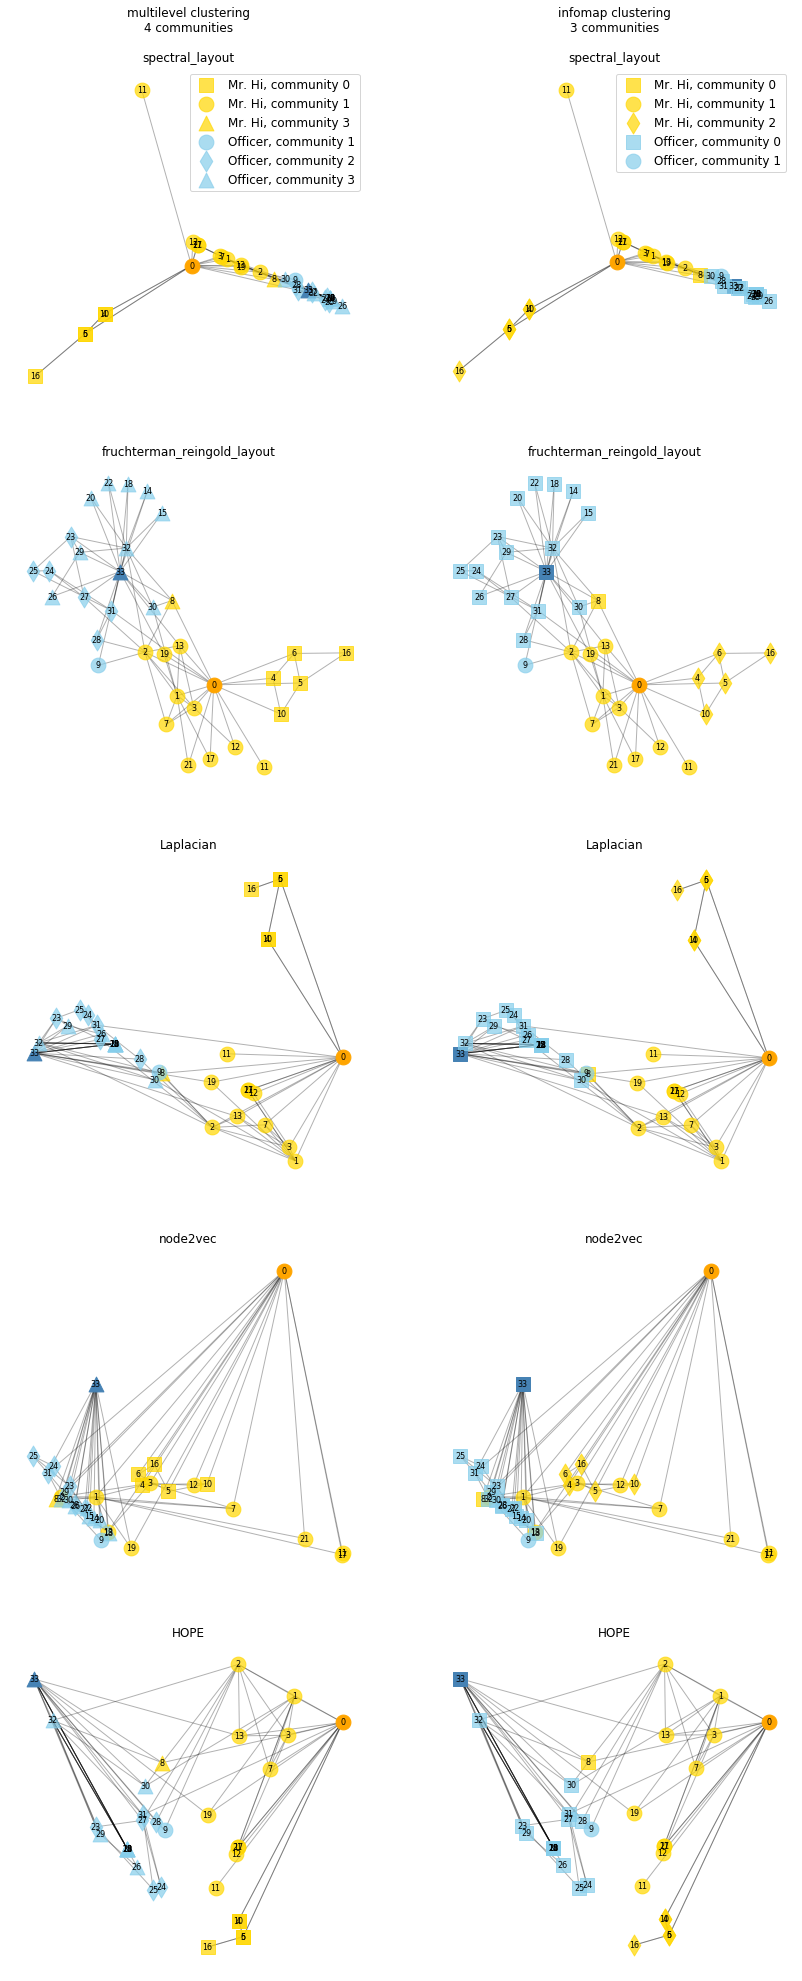

In [535]:
plot_size = 7
plot_num_cols = len(clusterings)
plot_num_rows = len(embeddings)
fig = plt.figure(figsize=(plot_num_cols * plot_size, plot_num_rows * plot_size))

index = 0
for communities in clusterings:
    for embedding in embeddings:
        ax = fig.add_subplot(plot_num_rows, plot_num_cols,\
                             index%plot_num_rows * plot_num_cols + index//plot_num_rows + 1)
        ax.axis('off')
        if index%plot_num_rows == 0:
            ax.title.set_text(f"{communities['name']} clustering\n{len(communities['split'])} communities\n\n{embedding['name']}")
        else:
            ax.title.set_text(embedding['name'])
        pos = embedding['positions']
        nx.draw_networkx_edges(karate_nx, pos=pos, alpha=0.3)
        nx.draw_networkx_labels(karate_nx, pos=pos, font_size=8)
        for club in ['Mr. Hi', 'Officer']:
            for community, label, shape in zip(communities['split'], range(99), cycle("sod^v><ph8")):
                plot_club_nodes(community, label, shape, club, pos=pos, node_size=220)
        if index%plot_num_rows == 0:
            plt.legend(prop={'size': 12})
        index += 1
    
plt.show()

**We observe that various clustering algorithms can result in different number of communities and that this number can be different than two.**

Arguably, multitude of informations drawn on the above plots can make them hard to look at. The default embedding method, the `fruchterman_reingold_layout`, seems to give most appealing plots for our graph. But, at the very least, **the many methods presented above underscore the importance of not trusting any one ambedding too much**.

---
## Graph Neural Network

Define some constants for later use

In [536]:
num_nodes = len(karate_nx)
num_features = len(karate_nx)
hidden_dim_0 = 16
hidden_dim_1 = 8
num_classes = 2

### Node features
It is typical for nodes in a graph to have some features associates with it. In such case we assign a vector (a fixed-length series of numbers) encoding those features to each node. For example, we could imagine knowing what was the age and sex of each member of the karate club, in which case we would assign to each node say a two-element array structured as (the age, the probability of being a woman).

Absent any such information, **we still want to assign vectors to our nodes, and so we just one-hot encode their labels**. In another words, $i$'th node gets assigned a vector $v_i = [0, \ldots, 0, 1, 0, \ldots]$ whose dimension equals the number of nodes and which is filled with zeros except in its $i$'th element where there is a single $1$.

Let's prepare a matrix of $v$ vectors (stacked as rows), and call it `X_in`.

Notice that we are using `numpy` arrays whenever we find it useful, and then we cast them as `torch.tensor`s. Also we need to settle on one numerical data-type: we stick to `float32`.

In [537]:
# initial node features
X_in = np.zeros((num_nodes, num_features), dtype='float32')
np.fill_diagonal(X_in, [1] * num_nodes)
# or just X_0 = np.eye(num_nodes) in our case
X_in = torch.tensor(X_in)
X_in

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

### The network's architecture
Workings of the neural network that we'd like to implement can be summarized as follows:
1. First, for each node, aggregate its feature vector $v$ and all vectors of its neighbors to an aggregate-vector. (E.g. take the element-wise mean of all those vectors.)
2. Apply a non-linear function to the aggregated feature vector (same function for each node) obtaining new features for each node (the dimension of the new features is chosen arbitrarily).
3. Repeat steps 1. and 2. using the newly obtained features and a new nonlinear function each time. The repetition can be done an arbitrary number of times (known as depth of the network), producing new features and using a new function each time.
4. Define a scalar function that will map all the (final) feature vectors into a single number. The function is kown as the loss function. Intutitively it is meant to measure the distance between current state of the network and a perfect model.

**Let us discuss and exemplify those steps one by one:**

### Feature aggregation
*Kipf and Welling* propose a specific aggregation of the feature vectors. Zoom in on $i$'th node:
* The function takes the current node's vector as well as vectors of all its neighbors.
* Each vector is multiplied by degree of the node it corresponds to raised to the power $-\frac{1}{2}$, as well as by the degree of the $i$'th node also to power $-\frac{1}{2}$.
* The vectors are summed element-wise.

The above precription can be succintly expressed as matrix multiplication involving the matrix of features stacked as rows $X$, the graphs adjacency matrix $A$ (https://en.wikipedia.org/wiki/Adjacency_matrix) and the graphs degree matrix $D$ (https://en.wikipedia.org/wiki/Degree_matrix).

In [182]:
# adjacency matrix
A = nx.adjacency_matrix(karate_nx).todense().astype('float32')

# adjacency matrix of the same graph with self-loops
A_ = np.eye(A.shape[0], dtype='float32') + A
A_ = torch.tensor(A_)

# node degrees
degrees = [degree for node, degree in list(karate_nx.degree())]

# the degree matrix to power (-1/2)
degrees_ = 1 / np.sqrt(degrees)
D_ = np.diag(degrees_).astype('float32')
D_ = torch.tensor(D_)

def aggregate(X):
    """Function to aggregate node features X (nodes correspond to rows of X).
    The new aggregate feature for each node V is obtained as
    weighted average of its present feature vector and the feacture vectors
    of its neighbors. Each vector in the sum is weighted by its degree to
    power -1/2 multiplied by the degree of V to power -1/2.
    This can be concisely written as the following matrix multiplication
    """
    return D_ @ A_ @ D_ @ X

### Nonlinear transformation

Define the following function and refer to it as **the activation function**. It is a shifted $tanh$

$
\sigma(x) = \frac{1}{1+\exp(-x)} \;.
$

It can be imported from `pytorch`.

In [ ]:
σ = torch.sigmoid

Here's a plot

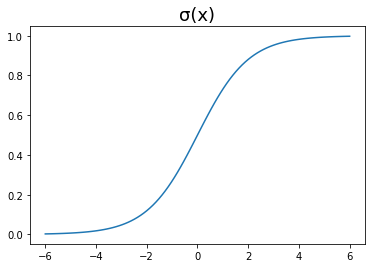

In [547]:
x = np.linspace(-6, 6, 100)
plt.plot(x, σ(torch.tensor(x)))
plt.title("σ(x)", fontsize=18)
plt.show()

Generally, many other activation functions are used and experimented with. The only universally necessary property of an activation function is that it is nonlinear.

Now we can express our nonlinear transformation: it is simply a right-multiplication by a matrix $W$ (known as the matrix of weights), followed by element-wise application of the the activation function.

In [548]:
def propagate(X, W):
    return σ(aggregate(X) @ W)

**Initially the $W$ is filled with random values.** The random distribution from which to draw elements in $W$ was itself a subject of scientific debate and experimentation. After the article *Understanding the difficulty of training deep feedforward neural networks* by Glorot, X. & Bengio, Y from 2010, the community has to a large extend settled on methods proposed there and often implemeted in deep-learning libraries like `pytorch`, see e.g.:
* https://pytorch.org/docs/stable/nn.init.html?highlight=init
* https://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

For simplicity we will simply use the standard gaussian for initialization of all elements in our weight matrices.

In [549]:
def init_(W): 
    W = torch.nn.init.normal_(W)
    #W = torch.nn.init.uniform_(W)
    #W = torch.nn.init.xavier_uniform_(W)
    #W = torch.nn.init.kaiming_uniform_(W)
    #W = torch.nn.init.xavier_normal_(W)
    #W = torch.nn.init.kaiming_normal_(W)
    return W

We will need as many weight matrices $W$ as many iteration described in the point 3. of "The network's architecture' above we want to make. First dimension of the first weight matrix is equal to the number of initial node features. And the second dimension of the last weight matrix can be reasonably chosen to be 2, given that we will try to use the final features to classify the nodes into one of two classes (we will come back to this point). All other dimensions can be chosen arbitrarily, they just need to match between iterations.

Take for example values that we have fixed before:

In [550]:
num_features, hidden_dim_0, hidden_dim_1, num_classes

(34, 16, 8, 2)

and use them to initialize three weight matrices $W_1$, $W_2$, $W_3$.

In [554]:
np.random.seed(1234)
torch.manual_seed(1234)

W_1 = torch.empty(num_features, hidden_dim_0)
W_1 = init_(W_1)

W_2 = torch.empty(hidden_dim_0, hidden_dim_1)
W_2 = init_(W_2)

W_3 = torch.empty(hidden_dim_1, num_classes)
W_3 = init_(W_3)

We can now use them to pass the initial features $X_0$ through our network and produce final 2-dimensional node features:

In [555]:
X_out = propagate(propagate(propagate(X_in, W_1), W_2), W_3)

E.g. here are the final features of the first five nodes:

In [556]:
X_out[:5]

tensor([[0.6298, 0.1856],
        [0.5805, 0.2645],
        [0.5368, 0.2674],
        [0.5406, 0.3181],
        [0.6319, 0.3445]])

### Graph embedding from the random weights

This brings us to the first main point of the blogpost by Thomas Kipf. **The very fact that we use the graph structure in the definition of the network (at the aggregation stage) serves to automatically produce *homophylic* features**: nodes that are closer together will tend to have similar features.

Let's look at some plots.

Since the final features are two-dimensional we can plot them directly on a plane.

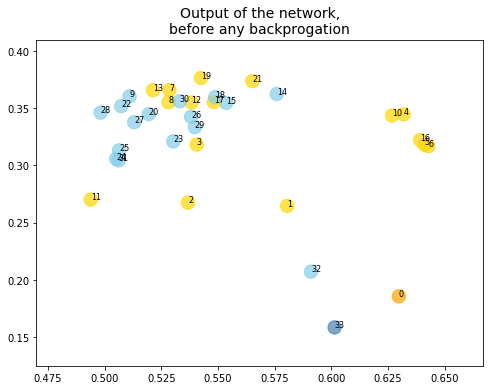

In [557]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(*X_out.T, c=colors, s=180, alpha=0.7)
for id_, coordinates in enumerate(X_out):
    ax.annotate(id_, coordinates, fontsize=8)
plt.title("Output of the network,\nbefore any backprogation",\
          fontsize = 14)
plt.show()

We can also truncate our network one layer short and have a look at the intermediate features, produced between $W_2$ and $W_3$. The only problem is that we have chosen them to be 8-dimensional. In order to plot them we'll use a linear projection defined by PCA (see: above).

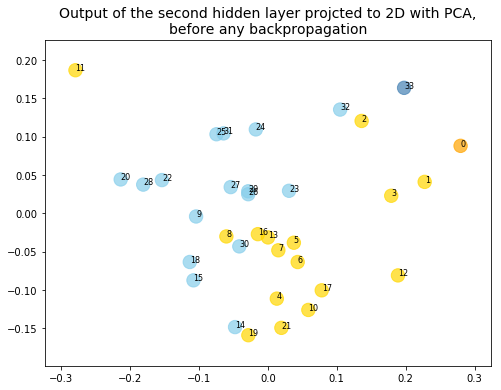

In [560]:
X_hidden = propagate(propagate(X_in, W_1), W_2)
X_hidden_pca = pca.fit_transform(X_hidden)
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(*X_hidden_pca.T, c=colors, s=180, alpha=0.7)
for id_, coordinates in enumerate(X_hidden_pca):
    ax.annotate(id_, coordinates, fontsize=8)
plt.title("Output of the second hidden layer projcted to 2D with PCA,\nbefore any backpropagation",\
          fontsize = 14)
plt.show()

We observe that the blue and yellow nodes are indeed somewhat separated.

In summary, **the neural network with random weights already serves to define a meaningful graph-embedding**, similarly to the traditional methods that we have examined earlier. This is despite the fact that the network is oblivious to any class-labels: we have not yet began to train the network.

### The network as a `pytorch` "layer"
`Pytorch` encourages us to wrap our network into a single class, where passing the input features `X_in` through all the described operations in order to obtain the final features `X_out` will be implemented as the `forward` method of the class:

In [567]:
class MyKarateConvolution(torch.nn.Module):
    
    def __init__(self, num_features, hidden_dim_0, hidden_dim_1, num_classes):
        super().__init__()
        """
        Store the D_ and A_ matrices, as well as the weight matrices
        as class-fields. The weight matrices can be implemented as
        `Linear` layers from `torch.nn`. This way `pytoch` will know
        that elements of those matrices are adjustable parameters that
        we will want to differentiate with respect to.
        """
        karate_nx = nx.karate_club_graph()
        A = nx.adjacency_matrix(karate_nx).todense().astype('float32')
        A_ = np.eye(A.shape[0], dtype='float32') + A
        self.A_ = torch.tensor(A_)
        degrees = [degree for node, degree in list(karate_nx.degree())]
        degrees_ = 1 / np.sqrt(degrees)
        D_ = np.diag(degrees_).astype('float32')
        self.D_ = torch.tensor(D_)
        self.W_1 = torch.nn.Linear(num_features, hidden_dim_0, bias=False)
        torch.nn.init.normal_(W_1)
        self.W_2 = torch.nn.Linear(hidden_dim_0, hidden_dim_1, bias=False)
        torch.nn.init.normal_(W_2)
        self.W_3 = torch.nn.Linear(hidden_dim_1, num_classes, bias=False)
        torch.nn.init.normal_(W_1)

    def _aggregate(self, X):
        return self.D_ @ self.A_ @ self.D_ @ X
    
    def _propagate(self, X, W):
        """
        Notice that right-multiplication of M by W is
        implemented as calling W on M: W(M) = M * W   
        """
        return σ(W(self._aggregate(X)))
    
    def partial_forward(self, X_in):
        """This is defined for the purpose of plotting X_hidden.
        """
        X_hidden = self._propagate(self._propagate(X_in, self.W_1), self.W_2)
        return X_hidden

    def forward(self, X_in):
        X_hidden = self.partial_forward(X_in)
        X_out = self._propagate(X_hidden, self.W_3)
        return X_out
    

### The loss function
Before we can train our network we have to take a closer look at the final point in "the network's architecture":  definition of the loss function. Here we will use a function that may seem complicated but which actually is a common and well motivated choice: the crossentropy.

Recall that we wish to classify each node into one of two classes: call them `0` and `1` (since in `python` indexing starts at zero). We will transform the final 2D node feature $v_{out}^{i}$ (produced by our network for the $i$'th node) such that it can be interpreted as a discrete probability distributions of belonging to class `0` or `1`. This is typically done by the so called softmax function:

$
v_{out}^i \equiv [v_0^i, \; v_1^i]
\; \stackrel{softmax}{\longrightarrow} \;
\left[
\frac{\exp (v_0^i) }{\exp (v_0^i) \,+\, \exp (v_1^i)}, \frac{\exp (v_1^i)}{\exp (v_0^i) \,+\, \exp (v_1^i)}
\right]
\equiv
[p^i, 1-p^i] \;,
$

where we have denoted by $p^i$ the (*quasi*-)probability that node $i$ belongs to class `0`.

Now, there are two nodes for which we actually now the truth distribution:
* for the node `0` it is $d^0 = [1, 0]$
* and for node `33` it is $d^{33} = [0, 1]$.

Crossentropy is a good function to quantify distance between two probability distributions, when one of them is true and the other is meant as an approximation of the first one. *Aurélien Géron* has published a very nice explanation of the crossentropy function on Youtube: [A Short Introduction to Entropy, Cross-Entropy and KL-Divergence](https://www.youtube.com/watch?v=ErfnhcEV1O8&t=1s). Be sure to check it out.

So, we define our loss function as an average of the two crossentropies: between $softmax(v_{out}^{0})$ and $d^0$, and between $softmax(v_{out}^{33})$ and $d^{33}$. (Had we have more nodes whose class were known, we would be averaging more cressentropies.)

Because of the specific form of the $d^0$ and $d^{33}$ distributions, the final loss function simplifies to:

$
loss = - \frac{1}{2}\left[
\log \left( \frac{\exp (v_0^0) }{\exp (v_0^0) \,+\, \exp (v_1^0)} \right)
+\log \left( \frac{\exp (v_1^{33}) }{\exp (v_0^{33}) \,+\, \exp (v_1^{33})} \right)
\right]
$

Again, `pytorch` has ready-made functions for us that we can directly apply to our raw `X_out` outputs, to effectively implement the above procedure. Specifically we will use the `CrossEntropyLoss` object (see [documentation](https://pytorch.org/docs/stable/nn.html?highlight=cross%20entropy%20loss#torch.nn.CrossEntropyLoss)).

In [565]:
xe = torch.nn.CrossEntropyLoss()

To calculate the loss we need to call `xe` on:
* feature matrix of nodes `0` and `33`, `X_out[[0, 33]]`,
* list of labels of the truth classes that those nodes belong to, `[0, 1]`.

Here's how to calculate the loss function after single forward pass through out network (with the calculation of gadients disabled).

In [568]:
np.random.seed(123)
torch.manual_seed(123)

model = MyKarateConvolution(num_features, hidden_dim_0, hidden_dim_1, num_classes)

with torch.no_grad():
    X_out = model(X_in)
    loss = xe(X_out[[0, 33]], torch.tensor([0, 1]))
    print(f"loss = {loss.item()}")

loss = 0.6933813095092773


### Backpropagation
**Once we calculate value of the loss function, we can obtain its derivatives with respect to all the weights $W$. Then we use values of those derivatives** (which formally can be thought of as coefficients of objects known as gradients \mathbb{d} W, and which are commonly and confusingly referred to simply as "gradients") **to update the weights. `Pytorch` makes this calculation for us when we call the `loss.backward()` method. The employed algorithm of automatically calculating the gradients is known as *backpropagation***. It is an implementation of the chain rule from calculus.

After the `loss.backward()` call, the `W` objects in the `model` will have nonempty `W.grad` fields. The latter can be used by hand to update `W`s, e.g. by doing (schematically)

$
\epsilon = 10^{-4}
$

$
W \to W - \epsilon \, \mathbb{d} W\;.
$

Or, even more conveniently, **we can tie the weights `W`s to an `optimizer` object that will make this update for us**. (The $\epsilon$ parameter above is known as the *learning rate*.)

The process of
* passing `X_in` through our neural network
* calculating the loss
* computing the derivatives wrt the weights
* updating the weights

can be repated many times. Each such repetition is often referred to as an *epoch*. The final step on the above list, updating the weights is done by calling `optimizer.step()` method. But the latter needs to be preceded by the `optimizer.zero_grad()` call which zeroes the gradients from the previous epoch (without it the gradients would from all epochs would be summed).

**Here's our final code for training the network for 100 epochs** (and printing the loss at each 10'th epoch):

In [614]:
np.random.seed(123)
torch.manual_seed(123)

model = MyKarateConvolution(num_features, hidden_dim_0, hidden_dim_1, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=10) # lr = learning_rate

number_of_epochs = 100
for epoch in range(1, number_of_epochs + 1):
    # the so called forward pass
    X_out = model(X_in)
    # calculate loss
    loss = xe(X_out[[0, 33]], torch.tensor([0, 1]))
    if epoch % 10 == 0:
        print(f"Epoch {epoch:>3}: loss = {round(loss.item(),4)}")
    # reset gradients of the weights to zero
    optimizer.zero_grad()
    # calculate derivatives of the loss wrt the weights
    loss.backward()
    # update the gradients of the weights
    optimizer.step()

Epoch  10: loss = 0.6924
Epoch  20: loss = 0.6898
Epoch  30: loss = 0.6788
Epoch  40: loss = 0.7143
Epoch  50: loss = 0.6663
Epoch  60: loss = 0.6479
Epoch  70: loss = 0.6112
Epoch  80: loss = 0.5245
Epoch  90: loss = 0.4153
Epoch 100: loss = 0.3254


After having trained the network we can again plot the resulting node-features.

Let's start with the hidden 8-dimendinal features of a truncated network:

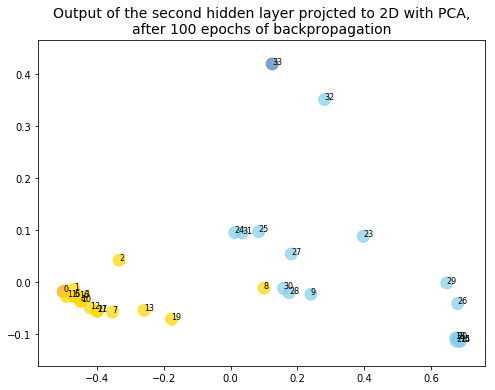

In [615]:
X_hidden = model.partial_forward(X_in).detach().numpy()
X_hidden_pca = pca.fit_transform(X_hidden)
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(*X_hidden_pca.T, c=colors, s=140, alpha=0.7)
for id_, coordinates in enumerate(X_hidden_pca):
    ax.annotate(id_, coordinates, fontsize=8)
plt.title(f"Output of the second hidden layer projcted to 2D with PCA,\nafter {number_of_epochs} epochs of backpropagation", fontsize=14)
plt.show()

And now have a look at the final 2-dimensional features.

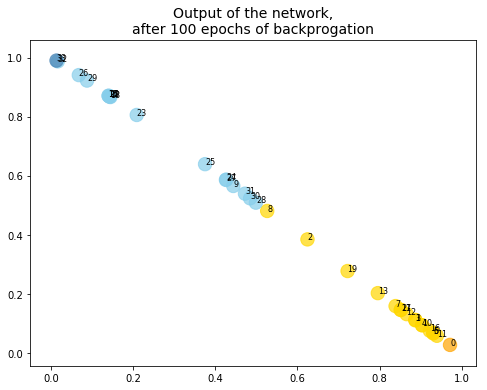

In [616]:
X_out = model(X_in).detach().numpy()
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(*X_out.T, c=colors, s=180, alpha=0.7)
for id_, coordinates in enumerate(X_out):
    ax.annotate(id_, coordinates, fontsize=8)
plt.title(f"Output of the network,\nafter {number_of_epochs} epochs of backprogation", fontsize=14)
plt.show()

**As expected, the model has put the two labelled nodes, `0` and `33` at opposite corners of the feature-space. All other nodes find themselfes somewhere inbetween. The blue and yellow nodes are clearly separated.**

---
## Label propagation by the Graph Neural Network
As the final test of the quality of the model, we use its predictions to label all other nodes.

(`X_out` is assumed to had been obtained in the previous section.)

In [617]:
predicted_classes = np.argmax(X_out, axis=1)
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Use the `predicted_classes` to define two communities:

In [618]:
communities_from_model = [[], []]
for id_, class_ in enumerate(predicted_classes):
    communities_from_model[class_].append(id_)

communities_from_model

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21],
 [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]

And plot those communities:

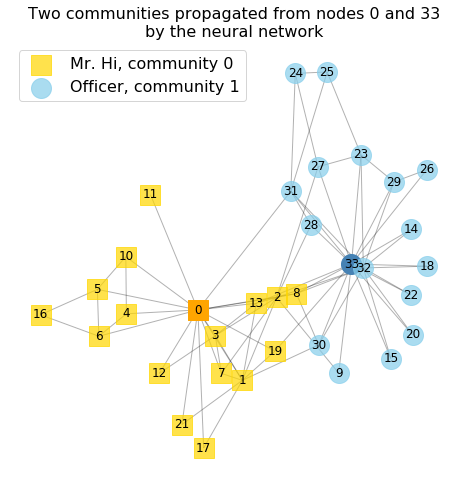

In [619]:
pos = nx.fruchterman_reingold_layout(karate_nx)
plt.figure(figsize=(8,8))
nx.draw_networkx_edges(karate_nx, pos=pos, alpha=0.3)
nx.draw_networkx_labels(karate_nx, pos=pos, font_size=12)
for club in ['Mr. Hi', 'Officer']:
    for community, label, node_shape in zip(communities_from_model, [0,1], cycle("sod^v><ph8")):
        plot_club_nodes(community, label, node_shape, club, pos, node_size=400)

plt.legend(prop={'size': 16})
plt.axis("off")
plt.title("Two communities propagated from nodes 0 and 33\nby the neural network", fontsize=16)
plt.show()

Ammusingly the neural network correctly predicted labels for all the nodes.

This was a random fluke, if we use a different random `seed` we get different results:

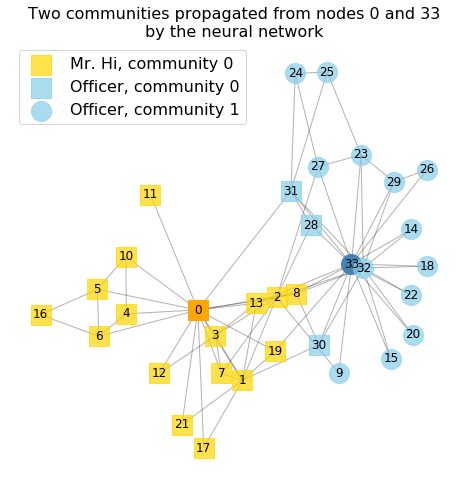

In [620]:
np.random.seed(1234)
torch.manual_seed(1234)

model = MyKarateConvolution(num_features, hidden_dim_0, hidden_dim_1, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=10) # lr = learning_rate
for epoch in range(1, number_of_epochs + 1):
    X_out = model(X_in)
    loss = xe(X_out[[0, 33]], torch.tensor([0, 1]))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 
    
X_out = model(X_in).detach().numpy()
predicted_classes = np.argmax(X_out, axis=1)
communities_from_model = [[], []]
for id_, class_ in enumerate(predicted_classes):
    communities_from_model[class_].append(id_)
plt.figure(figsize=(8,8))
nx.draw_networkx_edges(karate_nx, pos=pos, alpha=0.3)
nx.draw_networkx_labels(karate_nx, pos=pos, font_size=12)
for club in ['Mr. Hi', 'Officer']:
    for community, label, node_shape in zip(communities_from_model, [0,1], cycle("sod^v><ph8")):
        plot_club_nodes(community, label, node_shape, club, pos, node_size=400)
plt.legend(prop={'size': 16})
plt.axis("off")
plt.title("Two communities propagated from nodes 0 and 33\nby the neural network", fontsize=16)
plt.show()

---
## Summary
1. We have demonstrated graph-embeddings and node-clusterings obtained with some traditional algorithms.
2. We have demonstrated the inner workings of a simple Graph Convolution Neural Network proposed in *T. Kipf, M. Welling (ICLR 2017)*, following the discussion of one of the Authors published as a blogpost.
3. We have witnessed how the *inductive bias* encoded in the neural network's architecture makes it capable of transferring information from the graph structure into the node features already during the forward-pass. See [Relational inductive biases, deep learning, and graph networks](https://arxiv.org/abs/1806.01261) for a very insightful discussion about this sort of things.
4. We have used the Graph Convolution Neural Network to classify the nodes obtaining results on par with traditional methods.


---
## TODO

Take a dive into professional libraries and frameworks for analyzing graphs with neural networks. The approach presented here relied on the fact that the studied graph was very small. But huge graphs that encode structure of whole societies, internet-networks, citation-networks, ecological biomes, biochemical systems, ... are much more interesting and pose many new challanges. (If You don't yet find Yourself strapped to the hype-train firmly enough watch those talks: [Geometric Deep Learning on Graphs and Manifolds - #NIPS2017](https://www.youtube.com/watch?v=LvmjbXZyoP0), [Xavier Bresson: "Convolutional Neural Networks on Graphs"](https://www.youtube.com/watch?v=v3jZRkvIOIM&t=12s)) To analyze such graphs You'll probably want to emply one of the existing frameworks:
* [Graph Nets library](https://github.com/deepmind/graph_nets) for *Tensorflow*
* [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for *PyTorch* ([video introduction](http://www.ipam.ucla.edu/abstract/?tid=15592&pcode=GLWS4), [blogpost](https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8))
* [Deep Graph Library](https://github.com/dmlc/dgl) for *MXNet*
* [GeometricFlux](https://github.com/yuehhua/GeometricFlux.jl) for *Julia*

Iteresting graph datasets can be found here:
* https://linqs.soe.ucsc.edu/data
* https://networkdata.ics.uci.edu/
* biochemical:
  * https://snap.stanford.edu/biodata/index.html,
  * https://string-db.org/cgi/download.pl,
  * https://rth.dk/resources/rain/download.html

If You are interested in learning some general theory about graphs, take a look at the following resources:
* A list of [papers](https://github.com/thunlp/GNNPapers) about GraphNNs with over 4k stars on Github
* [Spectral Graph Theory, Fall 2015](http://www.cs.yale.edu/homes/spielman/561/), notes from a gradute course
* [Data Science & Complex Networks](http://book.complexnetworks.net/), a book with code
* A modern [textbook](https://www.amazon.com/Multilayer-Networks-Structure-Ginestra-Bianconi-ebook/dp/B07H3YWM7L/ref=sr_1_1?keywords=ginestra+bianconi&qid=1568498934&s=gateway&sr=8-1) that You'd probably have to pay for
